## PyTorch 학습 레벨 2 - 004
---

### 순서
1. _~~Tensor를 사용한 신경망~~_
2. torch.nn.functional 사용하기
3. optm을 이용하여 리팩토링 하기
4. fit() 와 get_data() 생성하기
5. CNN 으로 넘어가기

### Tensor를 사용한 신경망
- 신경망 구축
    - FashionMNIST 분류기(입력: 784, 출력: 10)
    - 가중치와 편향을 가지는 선형모델
    - 활성화 함수 : log softmax
    - 손실 함수 : negative log-likelihood
    - 평가 지표 : accuracy
    - training loop에서는 아래의 동작을 수행
        - 데이터에서 배치(64)를 선택 `DataLoader` 사용
        - 모델을 이용하여 예측 수행
        - 손실 계산
        - `backward()`를 이용하여 모델의 weight, bias 기울기 업데이트

#### 데이터 준비
- [FashionMNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist) 데이터셋을 다운로드
- `TorchVison` 직접사용과 달리, 데이터셋 다운로드 후 이를 직접 정의한 `CustomDataset` 사용
- `data`폴더에 다운로드, `wget` 패키지로 다운로드
- FashionMNIST 데이터셋은 60000개의 학습용 데이터와 100000개의 테스트용 데이터로 구분
- 학습용 데이터 중 10%(6000개)를 validation set으로 분리

In [54]:
# wget 모듈 설치
!pip install wget

In [55]:
from sklearn.model_selection import train_test_split
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import math
import time

device = torch.device('cpu')
# device = torch.device('cuda')  ## 여기서 GPU 사용하지 말것

In [56]:
import wget

In [57]:
urls = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz']

for url in urls:
    # data 폴더 하위에 url에 게재되어 있는 자료를 다운도르 받는다 
    wget.download(url, './data')

In [58]:
# code source : https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
# gz 파일을 열어 이미지와 라벨을 읽어들여 반환
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
        labels = labels.astype(np.int64)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images/255.0, labels


x_train, y_train = load_mnist('data', kind='train')
# sckit-learn의 train_test_split() 함수가 데이터 분리시 가장 편리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
x_test, y_test = load_mnist('data', kind='t10k')

print(f'train : image{x_train.shape}/{type(x_train[0])}, label{y_train.shape}/{type(y_train[0])}')
print(f'valid : image{x_val.shape}/{type(x_val[0])}, label{y_val.shape}/{type(y_val[0])}')
print(f'test  : image{x_test.shape}/{type(x_test[0])}, label{y_test.shape}/{type(y_test[0])}')

train : image(54000, 784)/<class 'numpy.ndarray'>, label(54000,)/<class 'numpy.int64'>
valid : image(6000, 784)/<class 'numpy.ndarray'>, label(6000,)/<class 'numpy.int64'>
test  : image(10000, 784)/<class 'numpy.ndarray'>, label(10000,)/<class 'numpy.int64'>


#### 커스텀 데이터셋/데이터로더 정의
- lbl203_*.ipynb에 정의한 CustomImageDataset과 차이 있음
- 커스텀 데이터셋에서는 `__init__`, `__len__`, `__getitem__`을 정의해야 하면 각 메서드에서는 다음과 같은 작업을 수행
    - `__init__` : 클래스의 멤버변수 x, y, transform, target_transform을 파라미터를 이용하여 초기화. x는 image 데이터/y는 라벨/transform은 이미지에 적용 될 transform/target_transform은 라벨에 적용 될 transform을 의미
    - `__len__` : 데이터셋의 샘플 개수를 반환
    - `__getitem__` : 주어진 인덱스에 해당하는 샘플을 (image, label) 쌍으로 반환. 이때, image에는 transform을 적용하고 라벨에는 target_transform을 적용하여 반환


In [59]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        self.labels = ['T-Shirt',  'Trouser', 'Pullover', 'Dress', 'Coat', 
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
        
        self.x = x # 이미지
        self.y = y # 라벨
        self.transform = transform # 이미지에 적용 될 transform
        self.target_transform = target_transform # 라벨에 적용 될 transform

    def __len__(self):
        return len(self.y) # 데이터셋의 샘플 개수

    def __getitem__(self, idx): # 주어진 idx번째에 해당하는 샘플을 반환
        img = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(img)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

- training loop에서는 배치를 선택하는 구간이 존재. 이를 수월하기 진행하기 위하여 위에서 `DataLoader`를 이용
- `DataLoader` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate) 가능. 
    - 아래의 각 순회(iteration)는 (각각 `batch_size=64` 의 특징(feature)과 정답(label)을 포함하는) `train_features` 와 `train_labels` 의 묶음(batch)을 반환
    - `shuffle=True` 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞임. 
    - (데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) 를 참조)

In [60]:
train_ds = CustomImageDataset(x_train, y_train, 
                              transform=torch.Tensor)
val_ds = CustomImageDataset(x_val, y_val, 
                            transform=torch.Tensor)

x_test = torch.Tensor(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device) # from_numpy() : np.array를 tensor로 변환

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

train_dl, val_dl

(<torch.utils.data.dataloader.DataLoader at 0x1b7313ac890>,
 <torch.utils.data.dataloader.DataLoader at 0x1b692d8e250>)

##### 정상생성 확인

In [61]:
def get_label_name(label): # 라벨(숫자)를 입력받아 해당 라벨의 의미를 반환
    LABLE_NAMES = ['T-Shirt',  'Trouser', 'Pullover', 'Dress', 'Coat', 
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
    return LABLE_NAMES[label]

In [62]:
def show_batch(features, labels):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, 65):
        img = features[i-1]
        label = get_label_name(labels[i-1])
        ax = fig.add_subplot(8, 8, i)
        
        
        if device.type  == 'cuda':
            img = img.cpu()
        ax.imshow(img.reshape(28,28), cmap='gray_r')
        ax.set_title(label)
        ax.set_xticks([]), ax.set_yticks([])

    plt.tight_layout()
    plt.show()

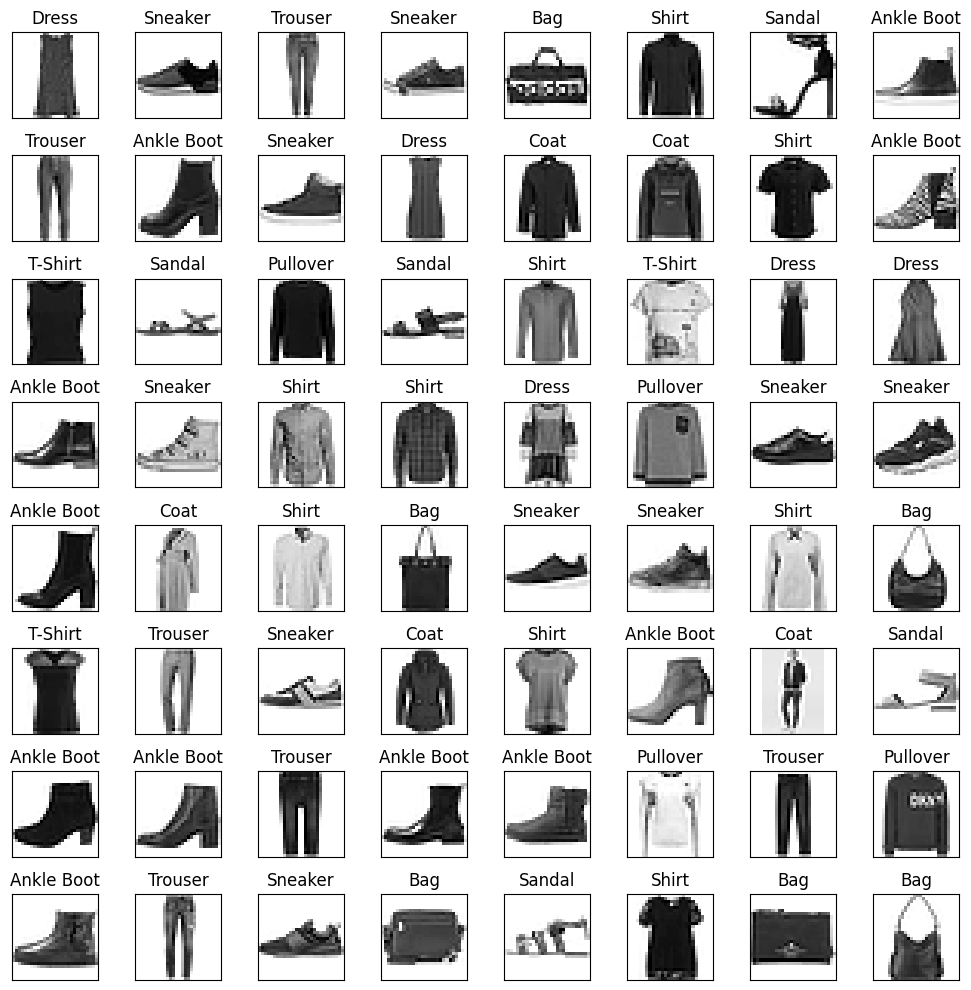

In [63]:
features, labels = next(iter(train_dl))
features, labels = features.to(device), labels.to(device)
show_batch(features, labels)

#### 신경망 정의

##### 가중치
- 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메서드를 제공, 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 예정
- 우리는 PyTorch에게 이들이 기울기(gradient)가 필요하다고 알려줌
- 이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록, *자동적으로* 역전파(back-propagation) 동안에 기울기를 계산할 수 있음
- 가중치에 대해서는 `requires_grad_` 를 초기화(initialization) **다음에** 설정. 왜냐하면 해당 단계가 기울기에 포함되는 것을 원치 않기 때문
    - (PyTorch에서 `_` 다음에 오는 메서드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미)

- [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 기법을 이용하여 가중치 초기화.
    - Standard gaussian을 이용해 생성한 난수를 '입력의 수'로 나누어 스케일링. 이에 대해서는 cs231n lec6에 다뤄짐


- 입력이미지는 reshape로 28 * 28로 변경하였고, 28 x 28 = 784
- 라벨(출력) 개수는 10개 

In [64]:
weights = torch.randn(784, 10, device=device) / math.sqrt(784) # 784열 10행 크기의 평균이 0 이고 분산이 1인 정규 분포(표준 정규 분포라고도 함)의 난수로 채워진 텐서를 반환
weights.requires_grad_()
bias = torch.zeros(10, device=device, requires_grad=True)
weights, bias

(tensor([[ 0.0159, -0.0333,  0.0764,  ..., -0.0439, -0.0095,  0.0239],
         [-0.0277,  0.0504, -0.0635,  ..., -0.0220,  0.0193, -0.0116],
         [-0.0365, -0.0471,  0.0142,  ...,  0.0014, -0.0649, -0.0123],
         ...,
         [-0.0054,  0.0525, -0.0839,  ...,  0.0449,  0.0194,  0.0209],
         [ 0.0390,  0.0401,  0.0023,  ..., -0.0058, -0.0828, -0.0230],
         [-0.0193, -0.0344, -0.0008,  ...,  0.0125,  0.0111,  0.0034]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

#### 모델, 활성화 함수
- PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수(또는 호출 가능한 객체)를 모델로 사용 가능
- 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용
- 활성화 함수(activation function)가 필요하므로,`log_softmax` 를 구현하고 사용

In [65]:
# softmax 함수에 log를 취한것과 동일
# 하지만, 두 연산을 따로 수행하는 것보다 더 빠르고 수치적으로 안정적
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # unsqueeze() : 특정위치에 1인차원을 추가함

def model(xb):
    return log_softmax(xb @ weights + bias)  # 점곱(dot product) 연산

- 실제적으로 PyTorch에서는 ReLU 활성화 함수가 가장 많이 쓰임.
- log_softmax 정의를 알고 싶으면 [링크](https://discuss.pytorch.org/t/log-softmax-function-in-pytorch-tutorial-example/52041)

- `@` 기호는 점곱(dot product) 연산
- 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출

In [66]:
preds = model(features)  # 예측
print(f'preds[0] : {preds[0]}\npreds.shape : {preds.shape}')

preds[0] : tensor([-2.8868, -2.3826, -1.5564, -1.6993, -2.4079, -3.0220, -2.5171, -2.7223,
        -2.4933, -2.4026], grad_fn=<SelectBackward0>)
preds.shape : torch.Size([64, 10])


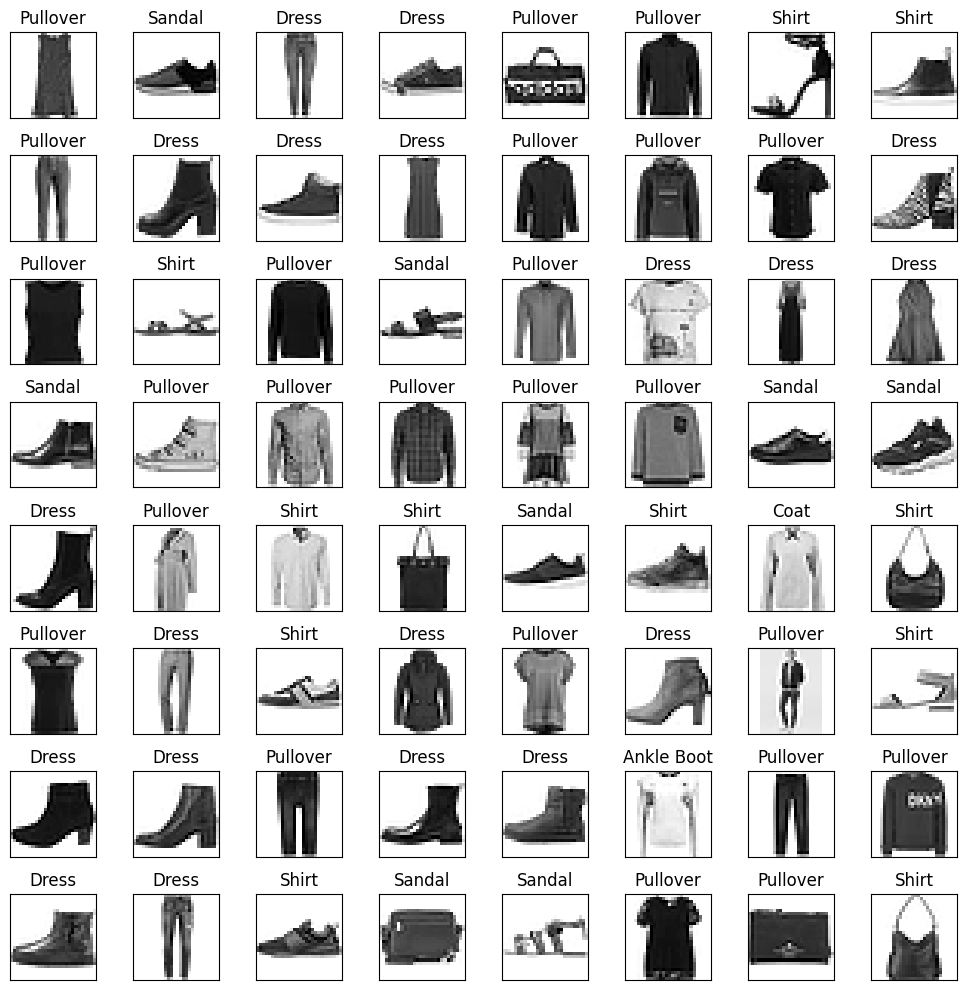

In [67]:
preds_label = torch.argmax(preds, -1)
show_batch(features, preds_label)

- 예측 결과가 엉망(!)이라는 것을 알 수 있음

#### 손실 함수

- `preds` 텐서(tensor)는 텐서 값 외에도, 기울기 함수(gradient function)를 포함.
- 나중에 이것을 역전파(backpropagation)를 위해 사용
- 손실함수 차례  `음의 로그 우도(Negative Log-Likelihood)`를 구현

- SoftMax

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0021.png" width="700">

- Negative Log-Likehood(NLL)

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0022.png" width="700">

- `Negative Log Likelihood (NLL)`는 분류 문제에서 주로 사용되는 손실 함수. 예측된 확률 분포와 실제 레이블 간의 차이를 측정
- `nll 함수`는 pred (모델의 예측)와 target (정답 레이블)을 입력으로 받아서, 각 샘플에 대해 다음과 같은 작업을 수행
    - `pred[range(target.shape[0]), target]` - 각 샘플의 실제 클래스에 해당하는 예측 확률을 선택
    - `range(target.shape[0])`는 각 샘플의 인덱스
    - `target`은 각 샘플에 대한 실제 클래스 레이블. 이 둘을 이용, 예측 확률에서 실제 클래스에 해당하는 확률값 추출

- 예
    -  target = [1, 2, 0]
    - 
        `python
        pred = [[0.1, 0.2, 0.7],
                [0.3, 0.4, 0.3],
                [0.9, 0.05, 0.05]]
        `
    - pred[range(3), target]은 [0.2, 0.3, 0.9] (실제 클래스에 해당하는 확률 값들)
    - `-pred[range(target.shape[0]), target]` -  `-log(p)` 계산
    - `mean()` - 손실 값의 평균

In [68]:
def nll(pred, target):
    return -pred[range(target.shape[0]), target].mean()

loss_func = nll # 손실함수를 nll로 지정

- 무작위 모델에 대한 손실을 점검

In [69]:
yb =labels
print(loss_func(preds, yb))

tensor(2.3280, grad_fn=<NegBackward0>)


#### 평가지표 accuracy
- 모델의 정확도(accuracy)를 계산하기 위한 함수를 구현. 매 예측마다, 만약 가장 큰 값의 인덱스가 목표값(target value)과 동일하다면, 그 예측은 올바른 것

In [70]:
def accuracy(out, yb): # yb: y batch
    preds = torch.argmax(out, dim=1) # torch.argmax(입력, dim) : 차원(dim)에서 (입력)텐서의 최대값 인덱스를 반환
    return (preds == yb).float().mean()

In [71]:
print(accuracy(preds, yb))

tensor(0.1406)


<div class="alert alert-info">
    <b>📌 Tip</b><p>This is an info alert box.</p>
</div>

<div class="alert alert-success">
    This is a success alert box.
</div>

<div class="alert alert-warning">
    This is a warning alert box.
</div>

<div class="alert alert-danger">
    This is a danger alert box.
</div>

- `class="alert alert-light"`, `class="alert alert-dark"`, `class="alert alert-primary"`, `class="alert alert-secondary"` 는 사용 권하지 않음. 모양 똑같음
- `class="alert alert-dark"` 하나만 사용하면 동일한 효과

<div class="alert alert-dark">
    This is a dark alert box.
</div>

#### training loop(훈련 루프) 정의
- 훈련 루프(training loop)를 실행 가능. 매 반복마다, 우리는 다음을 수행
    - 데이터의 미니배치를 선택
    - 모델을 이용하여 예측 수행
    - 손실 계산
    - `loss.backward()` 를 이용하여 모델의 기울기 업데이트, 이 경우에는, `weights` 와 `bias`.

- 이 기울기들을 이용하여 가중치와 절편을 업데이트
- 이것을 `torch.no_grad()` 컨텍스트 매니져(context manager) 내에서 실행 - 이러한 실행이 다음 기울기의 계산에 기록되지 않기위해서
- PyTorch의 자동 기울기(Autograd)가 어떻게 연산을 기록 [링크](https://pytorch.org/docs/stable/notes/autograd.html) 확인

- 이후 기울기를 0으로 설정합니다, 그럼으로써 다음 루프(loop)에 준비
- 그렇지 않으면, 우리가 계산한 기울기들은 일어난 모든 연산의 누적 집계를 기록
    - `loss.backward()` 가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 *더하게* 됨됨

In [72]:
from IPython.core.debugger import set_trace

# 모델 훈련 전에 손실값과 정확도를 출력
print(f'[before] loss : {loss_func(model(x_test), y_test)}')  # 훈련 전에 테스트 데이터로 손실
print(f'[before] acc : {accuracy(model(x_test), y_test)}')  # 훈련 전에 테스트 데이터로 정확도

lr = 0.5  # 학습률(learning rate)
epochs = 8  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):     # 에폭만큼 훈련 반복
    # 훈련 데이터셋을 미니배치로 순회
    for xb, yb in train_dl:
        # set_trace()를 활성화하면 디버깅을 위한 브레이크포인트가 설정됩니다.
        # set_trace()

        # 입력 데이터와 레이블을 지정된 device (GPU 또는 CPU)로 이동
        xb = xb.to(device) # 지정된 device및 (선택 사항) 텐서를 반환
        yb = yb.to(device)

        pred = model(xb)  # 모델 예측값 계산
        loss = loss_func(pred, yb)      # 손실 함수 계산

        loss.backward()     # 손실값에 대해 역전파(Backpropagation) 수행

        with torch.no_grad():        # torch.no_grad()를 사용하여 그래디언트를 추적하지 않음
            # 가중치 업데이트 (경사하강법)
            weights -= weights.grad * lr        # 학습률을 곱해서 가중치 업데이트
            bias -= bias.grad * lr              # 학습률을 곱해서 바이어스 업데이트

             # 다음 업데이트를 위해 그래디언트 초기화
            weights.grad.zero_()        # 가중치의 그래디언트를 0으로 초기화
            bias.grad.zero_()           # 바이어스의 그래디언트를 0으로 초기화
            

    # 매 에폭 후에 검증 데이터셋으로 모델 성능 평가
    with torch.no_grad():           # 검증 데이터에서는 기울기 계산을 하지 않음
        val_loss, val_acc = 0, 0

        # 검증 데이터셋을 미니배치로 순회
        for xb, yb in val_dl:
            xb = xb.to(device)      # 입력 데이터
            yb = yb.to(device)      # 레이블

            # 검증 데이터셋에 대한 손실값 누적
            val_loss += loss_func(model(xb), yb)
             # 검증 데이터셋에 대한 정확도 누적
            val_acc += accuracy(model(xb), yb)

     # 매 에폭 후, 검증 손실과 정확도를 출력  
    print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')

# 훈련 후 손실과 정확도를 출력 (테스트 데이터에 대해)      
print(f'[after ] loss : {loss_func(model(x_test), y_test)}')  # 훈련 후 테스트 데이터로 손실
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')  # 훈련 후 테스트 데이터로 정확도를 출력

[before] loss : 2.2706141471862793
[before] acc : 0.13660000264644623
epoch 1 >>> val loss(1.1083614), acc(0.7808068)
epoch 2 >>> val loss(0.8819935), acc(0.7952127)
epoch 3 >>> val loss(1.3096358), acc(0.8020279)
epoch 4 >>> val loss(2.9426296), acc(0.7039561)
epoch 5 >>> val loss(0.9387674), acc(0.7875111)
epoch 6 >>> val loss(1.3588092), acc(0.7715536)
epoch 7 >>> val loss(1.4482601), acc(0.8122783)
epoch 8 >>> val loss(1.0021157), acc(0.8040226)
[after ] loss : 1.0572803020477295
[after ] acc : 0.7942000031471252


- Autograd에서 보았던 sin 함수 예측 신경망, 학습과정에 기울기를 0으로 설정했을 때와 그러지 않았을 경우로 차이를 봄

In [73]:
import torch
import math
import matplotlib.pyplot as plt

In [74]:
def get_grad_hist(mode):   # gradient 변화도 기록을 위해 사용하는 함수
    dtype = torch.float     # 데이터 타입 설정

    # x는 -π에서 π까지 2000개의 값으로 구성된 텐서
    x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
    y = torch.sin(x)        # y는 sin(x) 함수의 값

    # a, b, c, d는 초기화된 가중치들로, 학습할 변수로 설정
    a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

    grad_log = [[], [], [], []]     # 각 가중치의 기울기를 기록할 리스트

    learning_rate = 1e-6        # 학습률 설정
    for t in range(2000):       # 2000번의 반복으로 학습
         # y_pred는 a, b, c, d로 이루어진 3차 함수 모델
        y_pred = a + b * x + c * x ** 2 + d * x ** 3
        # 손실 함수: 예측 값과 실제 값의 차이를 제곱하여 더한 값
        loss = (y_pred - y).pow(2).sum()
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()

        # 그래디언트를 사용하여 가중치 업데이트 (torch.no_grad()로 기울기 추적을 비활성화)
        with torch.no_grad():
            a -= learning_rate * a.grad     # a 업데이트
            b -= learning_rate * b.grad     # b 업데이트
            c -= learning_rate * c.grad     # c 업데이트
            d -= learning_rate * d.grad     # d 업데이트

            # 기울기 기록
            grad_log[0].append(float(a.grad))   # a의 기울기 기록
            grad_log[1].append(float(b.grad))   # b의 기울기 기록
            grad_log[2].append(float(c.grad))   # 생략...
            grad_log[3].append(float(d.grad))

            if mode == 1:
                # mode가 1일 때, 가중치 갱신 후 기울기를 0으로 초기화
                a.grad = None
                b.grad = None
                c.grad = None
                d.grad = None
                
    return grad_log     # 기울기 기록을 반환

# 기울기 로그를 시각화하는 함수
def show_grad(grad_log, title):
    fig = plt.figure(figsize=(10, 7))       # 시각화할 Figure 객체 생성

    label = ['a', 'b', 'c', 'd']        # 각 그래프의 레이블
    for i in range(1, 5):           # a, b, c, d에 대해 4개의 서브플롯 생성
        ax = fig.add_subplot(2, 2, i)       # 2x2 서브플롯에서 위치 설정
        ax.plot(range(2000), grad_log[i-1], label=label[i-1])       # 기울기 변화를 그래프에 그리기
        ax.set_title(label[i-1])        # 각 서브플롯의 제목 설정
   
    fig.suptitle(title)     # 전체 Figure의 제목 설정
    plt.show()

In [75]:
grad_log_with_reset_gradient = get_grad_hist(1)
grad_log_with_acc_gradient = get_grad_hist(0)

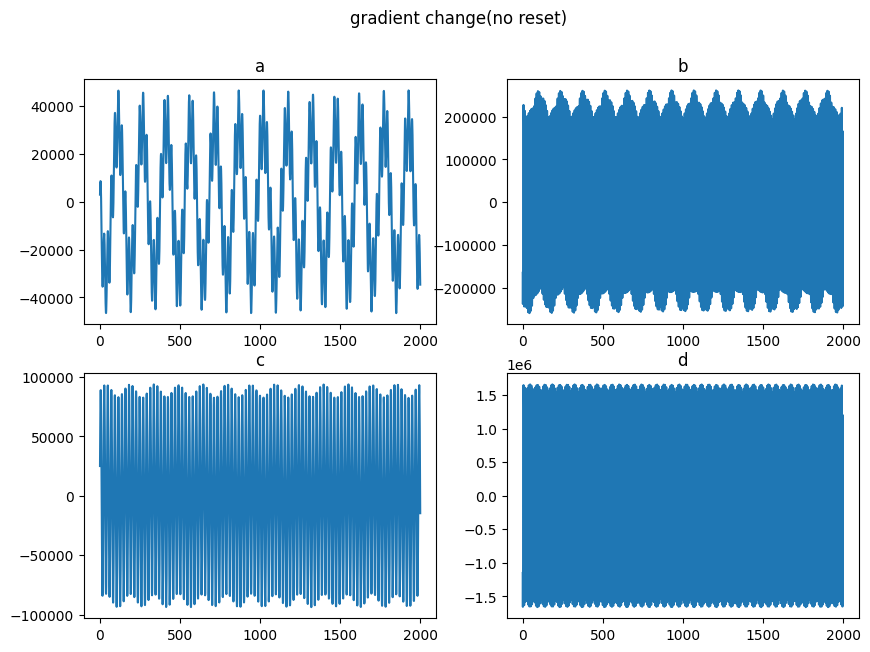

In [76]:
show_grad(grad_log_with_acc_gradient, 'gradient change(no reset)')

- 그래디언트의 값이 계속해서 커지며 변화. 기울기 폭주(gradient explosion) 문제 야기할 수 있음, 이로 인해 학습이 제대로 이루어지지 않는 상황

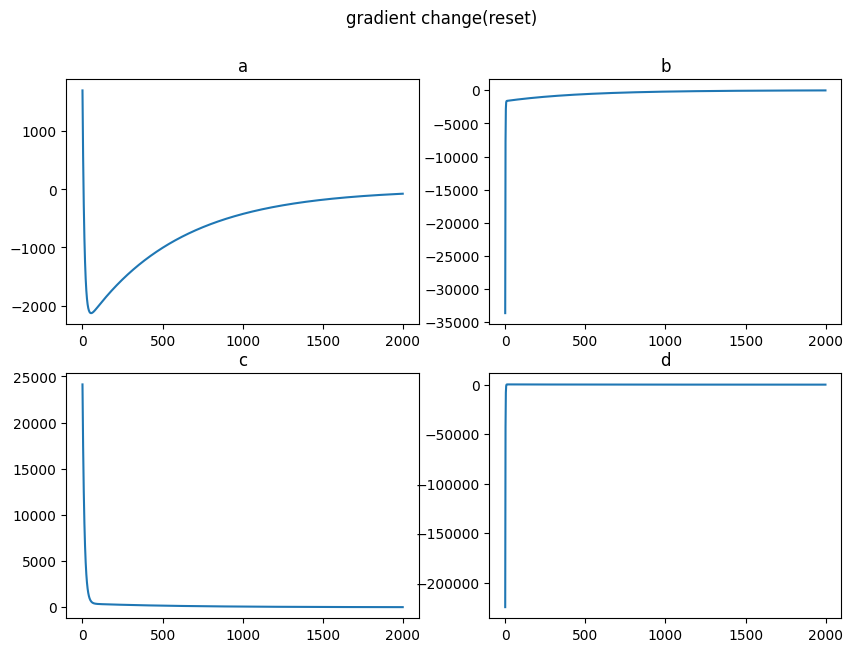

In [77]:
show_grad(grad_log_with_reset_gradient, 'gradient change(reset)')

- 그래디언트가 적절하게 수렴하는 것을 보임. 이 그래프는 가중치 갱신 후 기울기를 초기화(reset)하여, 기울기가 점차 안정되면서 수렴하는 과정
- 이는 학습이 잘 진행되고 있다는 신호

### 순서
1. Tensor를 사용한 신경망
2. _~~torch.nn.functional 사용하기~~_
3. optm을 이용하여 리팩토링 하기
4. fit() 와 get_data() 생성하기
5. CNN 으로 넘어가기

### torch.nn.functional 사용하기
- 코드를 리팩토링(refactoring). 이전과 동일하지만, PyTorch의 `nn` 클래스의 장점을 활용하여 더 간결하고 유연하게 생성
- 직접 작성했던 ~~활성화함수~~, ~~손실함수~~ 등을 `torch.nn.functional`에 존재하는 함수로 대체
- 관례적으로 네임스페이스를 import하며 `F`로 이름 변경
- 이 모듈에는 `torch.nn` 라이브러리의 모든 함수가 포함
- 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지 함수도 존재
- 만약 이전의 `log Softmax` 활성화와 `NLL` 손실을 사용하고자 하면, `F.cross_entropy` 사용하면 됨

In [78]:
import torch.nn.functional as F

In [79]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [80]:
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(1.0573, grad_fn=<NllLossBackward0>) tensor(0.7942)


In [81]:
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(1.0573, grad_fn=<NllLossBackward0>) tensor(0.7942)


#### nn.Module 을 이용하여 리팩토링
- 더 명확하고 간결한 훈련 루프를 위해 `nn.Module` 및 `nn.Parameter` 를 사용
- `nn.Module` (자체가 클래스이고 상태를 추척할 수 있는) 하위 클래스(subclass)를 생성
- Python의 module과 헷갈리지 말것

In [82]:
from torch import nn

In [83]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__() # super()로 기반 클래스(부모 클래스)를 초기화해줌으로써, 기반 클래스의 속성을 subclass가 받아오도록 한다. (초기화를 하지 않으면, 부모 클래스의 속성을 사용할 수 없음)
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

- 함수를 사용하는 대신에 이제는 오브젝트(object) 를 사용하기 때문에, 먼저 모델의 인스턴스화(instantiate) 필수 

In [84]:
model = Mnist_Logistic() # 인스턴스화
model.to(device)

Mnist_Logistic()

- 이전과 동일한 방식으로 손실을 계산
- `nn.Module` 오브젝트들은 마치 함수처럼 사용 (즉, 이들은 *호출가능*), 그러나 배후에서 Pytorch 는 우리의 `forward` 메소드를 자동으로 호출

In [85]:
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(2.4619, grad_fn=<NllLossBackward0>) tensor(0.1213)


- 이전에는 훈련 루프를 위해 이름 별로 각 매개변수 값을 업데이트하고 각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했음.

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

- 이제 model.parameters() 및 model.zero_grad() (모두 `nn.Module` 에 대해 PyTorch에 의해 정의됨)를 활용하여 이러한 단계를 더 간결하게 만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어 버리는 오류를 덜 발생

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
        model.zero_grad()
```

- 훈련 전에 항상 `model.train()`을 호출하고, 추론(inference) 전에 `model.eval()`을 호출
- `nn.BatchNorm2d` 및 `nn.Dropout`과 같은 레이어에서 이러한 다른 단계(훈련, 추론) 에 대한 적절한 동작이 일어나게 하기 위함

In [86]:
def fit(model, train_dl, val_dl): # 함수화 외에는 나머지 내용은 이전 반복로직과 동일!!
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():  # 더이상 weights, bias 불필요
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = 0, 0
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                val_loss += loss_func(model(xb), yb)
                val_acc += accuracy(model(xb), yb)

            print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')


print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

lr = 0.5  # 학습률(learning rate)
epochs = 7  # 훈련에 사용할 에폭(epoch) 수
fit(model, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.461937189102173
[before] acc : 0.12129999697208405
epoch 1 >>> val loss(1.2840121), acc(0.7616911)
epoch 2 >>> val loss(0.7053986), acc(0.8194259)
epoch 3 >>> val loss(0.7682904), acc(0.8086768)
epoch 4 >>> val loss(0.7477525), acc(0.8308954)
epoch 5 >>> val loss(0.8474919), acc(0.8157137)
epoch 6 >>> val loss(0.8494842), acc(0.8178192)
epoch 7 >>> val loss(0.9035476), acc(0.8042996)
[after ] loss : 0.9601974487304688
[after ] acc : 0.795199990272522


#### nn.Linear 를 이용하여 리팩토링
- `self.weights` 및 `self.bias`를 수동으로 정의 및 초기화하고, `xb  @ self.weights + self.bias`를 계산하는 대신에, 위의 모든 것을 해줄 Pytorch 클래스인 [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers)를 선형 레이어로 사용
- Pytorch에는 다양한 유형의 코드를 크게 단순화 할 수 있는 미리 정의된 레이어가 있고 이는 또한 종종 기존 코드보다 속도를 빠르게

In [87]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

- 이전과 같은 방식으로 모델을 인스턴스화하고 손실을 계산

In [88]:
model = Mnist_Logistic().to(device)
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(2.3076, grad_fn=<NllLossBackward0>) tensor(0.0785)


- 우리는 여전히 이전과 동일한 `fit` 메소드를 사용

In [89]:
print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

lr = 0.5  # 학습률(learning rate)
epochs = 8  # 훈련에 사용할 에폭(epoch) 수
fit(model, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.3075642585754395
[before] acc : 0.07850000262260437
epoch 1 >>> val loss(0.7857454), acc(0.8126662)
epoch 2 >>> val loss(1.0113095), acc(0.7696143)
epoch 3 >>> val loss(0.9140227), acc(0.7943817)
epoch 4 >>> val loss(0.8966446), acc(0.8007536)
epoch 5 >>> val loss(0.8584960), acc(0.8070146)
epoch 6 >>> val loss(0.6442242), acc(0.8411459)
epoch 7 >>> val loss(0.7535762), acc(0.8139960)
epoch 8 >>> val loss(0.6267271), acc(0.8350509)
[after ] loss : 0.6621344685554504
[after ] acc : 0.8212000131607056


### 순서
1. Tensor를 사용한 신경망
2. torch.nn.functional 사용하기
3. _~~optm을 이용하여 리팩토링 하기~~_
4. fit() 와 get_data() 생성하기
5. CNN 으로 넘어가기

### optm응 이용, 리팩토링 하기
- 다양한 최적화(optimization) 알고리즘을 가진 패키지인 `torch.optim`
- 각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 `step` 메소드를 사용하여 업데이트를 진행
- 이전 수동으로 코딩한 최적화 단계를 대체

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

대신에 아래로 대체

```python
opt.step()
opt.zero_grad()
```

- `optim.zero_grad()` 는 기울기를 0으로 재설정

In [90]:
from torch import optim

- 나중에 다시 사용할 수 있도록 모델과 옵티마이져를 만드는 작은 함수를 정의

In [91]:
def get_model():
    model = Mnist_Logistic().to(device)
    return model, optim.SGD(model.parameters(), lr=lr) # optim.SGD(parameter, learning_rate) : stochastic gradient descent 구현

In [92]:
model, opt = get_model()

epochs = 7

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            val_loss += loss_func(model(xb), yb)
            val_acc += accuracy(model(xb), yb)

    print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')
        
print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.3648388385772705
[before] acc : 0.04280000180006027
epoch 1 >>> val loss(0.9170389), acc(0.8099512)
epoch 2 >>> val loss(0.9133105), acc(0.7995346)
epoch 3 >>> val loss(1.0517020), acc(0.7889517)
epoch 4 >>> val loss(0.6675639), acc(0.8290116)
epoch 5 >>> val loss(0.7802050), acc(0.8330009)
epoch 6 >>> val loss(1.4716874), acc(0.7073360)
epoch 7 >>> val loss(0.6041015), acc(0.8424757)
[after ] loss : 0.6344831585884094
[after ] acc : 0.8374999761581421


### 순서
1. Tensor를 사용한 신경망
2. torch.nn.functional 사용하기
3. optm을 이용하여 리팩토링 하기
4.  _~~fit() 와 get_data() 생성하기~~_
5. CNN 으로 넘어가기

### fit() 와 get_data() 생성하기
- 훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 처리
- 하나의 배치에 대한 손실을 계산하는 자체 함수 `loss_batch` 로 생성
- 훈련 데이터셋에 대한 옵티마이저를 전달하고 이를 사용하여 역전파를 수행
- 검증 데이터셋의 경우 옵티마이저를 전달하지 않으므로 메소드가 역전파를 수행하지 않음

In [93]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

- `fit` 은 모델을 훈련하고 각 에폭에 대한 훈련 및 검증 손실을 계산하는 작업을 수행

In [94]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl] # zip(*iterable)의 *iterable은 반복 가능(iterable)한 자료형 여러 개를 입력할 수 있다는 의미
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # np.multiply(x1, x2): 인수를 요소별로 곱합니다.

        print("epoch : ", epoch, ", val_loss : ", val_loss)

In [95]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2), # 검증 데이터셋에 대해서는 역전파(backpropagation)가 필요하지 않으므로 
                                               # 메모리를 덜 사용하기 때문에 배치 사이즈를 늘릴 수 있다.
    )

- `get_data`는 학습 및 검증 데이터셋에 대한 dataloader 를 출력

In [96]:
bs = 64 # batch size
train_dl, val_dl = get_data(train_ds, val_ds, bs)
model, opt = get_model()

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

fit(epochs, model, loss_func, opt, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.369633197784424
[before] acc : 0.07540000230073929
epoch :  0 , val_loss :  0.9449777487119039
epoch :  1 , val_loss :  1.7446106595993043
epoch :  2 , val_loss :  0.8932848943074544
epoch :  3 , val_loss :  1.2178296626408895
epoch :  4 , val_loss :  0.9595538717905681
epoch :  5 , val_loss :  1.317973879814148
epoch :  6 , val_loss :  1.2218276077906292
[after ] loss : 1.2145445346832275
[after ] acc : 0.8015999794006348


### 중간정리
- MNIST Fashion dataset을 분류하는 간단한 선형 분류기를 아래의 단계를 걸치며 변형
    1. Tensor와 autograd만을 이용한 신경망 구축
    2. nn.functional을 이용하여 활성화 함수/손실 함수 대체 👉 해당 함수들을 직접 작성하지 않아도 되게 됨
    3. nn.Module를 이용하여 모델을 모듈화 👉 gradient 초기화가 간편해짐
    4. nn.Linear를 이용하여 모델 정의 👉 가중치/편향 초기화와 forward를 직접 작성하지 않아도 되게 됨
    5. optm을 이용하여 가중치 업데이트

### 순서
1. Tensor를 사용한 신경망
2. torch.nn.functional 사용하기
3. optm을 이용하여 리팩토링 하기
4. fit() 와 get_data() 생성하기
5. _~~CNN 으로 넘어가기~~_

### CNN 으로 넘어가기
- 이제 3개의 컨볼루션 레이어로 신경망을 구축.
- 이전 섹션의 어떤 함수도 모델의 형식에 대해 가정하지 않기 때문에, 별도의 수정없이 CNN을 학습하는 데 사용 가능

#### 1. nn.Module
- Pytorch 의 사전정의된 [Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) 클래스를 컨볼루션 레이어로 사용
- 3개의 컨볼루션 레이어로 CNN을 정의
- 각 컨볼루션 뒤에는 ReLU가 존재. 마지막으로 평균 풀링(average pooling)을 수행.(`view` 는 PyTorch의 numpy `reshape` 버전)

In [97]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1